##### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Bangla Article Classification With TF-Hub

This colab is a demonstration of using [Tensorflow Hub](https://www.tensorflow.org/hub/) for text classification in non-English/local languages. Here we choose [Bangla](https://en.wikipedia.org/wiki/Bengali_language) as the local language and use pretrained word embeddings to solve a multiclass classification task where we classify Bangla news articles in 5 categories.  The pretrained embeddings for Bangla comes from [fastText](https://fasttext.cc/docs/en/crawl-vectors.html) which is a library by Facebook with released pretrained word vectors for 157 languages. 

We'll use TF-Hub's pretrained embedding exporter for converting the word embeddings to a text embedding module first and then use the module to train a classifier with [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras), Tensorflow's high level user friendly API to build deep learning models.  Even if we are using fastText embeddings here, it's possible to export any other embeddings pretrained from other tasks and quickly get results with Tensorflow hub. 

# Prepare Environment

In [0]:
!pip install -q tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 348.9MB 54kB/s 
     |████████████████████████████████| 3.1MB 44.1MB/s 
     |████████████████████████████████| 501kB 53.1MB/s 


In [0]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# Dataset

We will use [BARD](https://www.researchgate.net/publication/328214545_BARD_Bangla_Article_Classification_Using_a_New_Comprehensive_Dataset) (Bangla Article Dataset) which has around 3,76,226 articles collected from different Bangla news portals and labelled with 5 categories : economy, state, international, sports and entertainment. 


In [0]:
!wget -O bard.zip https://github.com/Tahsin-Mayeesha/bard-dataset/blob/master/data.zip?raw=true

--2019-07-19 00:42:34--  https://github.com/Tahsin-Mayeesha/bard-dataset/blob/master/data.zip?raw=true
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Tahsin-Mayeesha/bard-dataset/raw/master/data.zip [following]
--2019-07-19 00:42:34--  https://github.com/Tahsin-Mayeesha/bard-dataset/raw/master/data.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/Tahsin-Mayeesha/bard-dataset/master/data.zip [following]
--2019-07-19 00:42:34--  https://media.githubusercontent.com/media/Tahsin-Mayeesha/bard-dataset/master/data.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|151.101.0.133|:443... connected

In [0]:
!unzip -q bard.zip
!ls

bard.zip  economy  entertainment  international  sample_data  sports  state


# Export pretrained word vectors to TF-Hub module

TF-Hub provides some handy scripts for converting word embeddings to TF-hub text embedding modules [here](https://github.com/tensorflow/hub/tree/master/examples/text_embeddings_v2).  To make the module for Bangla or any other languages we simply have to download the word embedding .txt or .vec file to the same directory as export_v2.py and run the script.


The exporter reads the embedding vectors and exports it to a Tensorflow [SavedModel](https://www.tensorflow.org/beta/guide/saved_model). A SavedModel contains a complete TensorFlow program including weights and graph. TF-Hub can load the SavedModel as a [module](https://www.tensorflow.org/hub/api_docs/python/hub/Module) which we will use to build the model for text classification. Since we are using tf.keras to build the model we will use [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) which provides a wrapper for a hub module to use as a Keras Layer.

First we will get our word embeddings from fastText and embedding exporter from TF-Hub [repo](https://github.com/tensorflow/hub).


In [0]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.bn.300.vec.gz
!wget https://raw.githubusercontent.com/tensorflow/hub/master/examples/text_embeddings_v2/export_v2.py
!gunzip cc.bn.300.vec.gz --k

--2019-07-19 00:44:09--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.bn.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.6.166, 104.20.22.166, 2606:4700:10::6814:6a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.6.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 881274182 (840M) [binary/octet-stream]
Saving to: ‘cc.bn.300.vec.gz’

cc.bn.300.vec.gz    100%[===================>] 840.45M  11.5MB/s    in 74s     

2019-07-19 00:45:24 (11.4 MB/s) - ‘cc.bn.300.vec.gz’ saved [881274182/881274182]

--2019-07-19 00:45:26--  https://raw.githubusercontent.com/tensorflow/hub/master/examples/text_embeddings_v2/export_v2.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7688 (7

Then we will run the exporter script on our embedding file. Since fastText embeddings has a header line and are pretty large(around 3.3 GB for bangla after converting to a module) we ignore the first line and export only the first 100,000 tokens to the text embedding module.

In [0]:
!python export_v2.py --embedding_file=cc.bn.300.vec --export_path=text_module --num_lines_to_ignore=1 --num_lines_to_use=100000

2019-07-19 00:46:46.787087: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcuda.so.1
2019-07-19 00:46:46.867253: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1006] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-07-19 00:46:46.867808: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1640] Found device 0 with properties: 
name: Tesla T4 major: 7 minor: 5 memoryClockRate(GHz): 1.59
pciBusID: 0000:00:04.0
2019-07-19 00:46:46.886005: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcudart.so.10.0
2019-07-19 00:46:47.093647: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcublas.so.10.0
2019-07-19 00:46:47.173860: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcufft.so.10.0


In [0]:
module_path = "text_module/"
embedding_layer = hub.KerasLayer(module_path,trainable=False)

The text embedding module takes a batch of sentences in a 1D tensor of strings as input and outputs the embedding vectors of shape (batch_size,embedding_dim) corresponding to the sentences. It preprocesses the input by splitting on spaces. Word embeddings are combined to sentence embeddings with the `sqrtn` combiner(See [here](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup_sparse)). For demonstration we pass a list of Bangla words as input and get the corresponding embedding vectors.

In [0]:
embedding_layer(['বাস', 'বসবাস', 'ট্রেন', 'যাত্রী', 'ট্রাক']) 

<tf.Tensor: id=268, shape=(5, 300), dtype=float64, numpy=
array([[ 0.0462, -0.0355,  0.0129, ...,  0.0025, -0.0966,  0.0216],
       [-0.0631, -0.0051,  0.085 , ...,  0.0249, -0.0149,  0.0203],
       [ 0.1371, -0.069 , -0.1176, ...,  0.029 ,  0.0508, -0.026 ],
       [ 0.0532, -0.0465, -0.0504, ...,  0.02  , -0.0023,  0.0011],
       [ 0.0908, -0.0404, -0.0536, ..., -0.0275,  0.0528,  0.0253]])>

# Convert to Tensorflow Dataset 


Since the dataset is really large instead of loading the entire dataset in memory we will use a generator to yield samples in run-time in batches using [Tensorflow Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) functionalities.  The dataset is also very imbalanced, so before using the generator we will shuffle the dataset. 


In [0]:
dir_names = ['economy','sports','entertainment','state','international']

file_paths = []
labels = []
for i,dir in enumerate(dir_names):
  file_names = ["/".join([dir,name]) for name in os.listdir(dir)]
  file_paths+=file_names
  labels+= [i]*len(os.listdir(dir))
  
np.random.seed(42)
permutation = np.random.permutation(len(file_paths))

file_paths = np.array(file_paths)[permutation]
labels = np.array(labels)[permutation]

We can check the distribution of labels in the training and validation examples after shuffling.

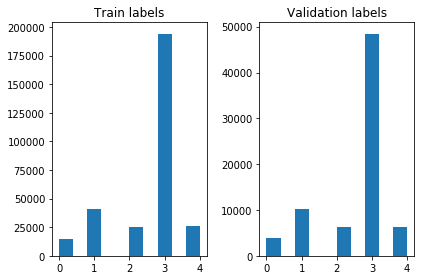

In [0]:
# plot training vs validation distribution
train_size = int(len(file_paths)*0.80)
plt.subplot(1,2,1)
plt.hist(labels[0:train_size])
plt.title("Train labels")
plt.subplot(1,2,2)
plt.hist(labels[train_size:])
plt.title("Validation labels")
plt.tight_layout()

To create a [Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) using generator we first write a generator function which reads each of the articles from file_paths and the labels from the label array, and yields one training example at each step. We pass this generator function to the [tf.data.Dataset.from_generator](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_generator) method and specify the output types. Each training example is a tuple containing an article of tf.string data type and one-hot encoded label. We split the dataset with a train-validation split of 80-20 using the [`skip`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#skip) and [`take`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) method.

In [0]:
def gen():
  for i,file in enumerate(file_paths):
      label = tf.keras.utils.to_categorical(labels[i],num_classes=5)
      article = tf.io.read_file(file)
      yield article,label

In [0]:
def make_dataset(train_size):
  data = tf.data.Dataset.from_generator(generator=gen,output_types=(tf.string,tf.float32))
  train_size = int(train_size*len(file_paths))
  train_data = data.take(train_size)
  validation_data = data.skip(train_size)
  return train_data,validation_data

In [0]:
train_data, validation_data = make_dataset(0.80)

W0719 00:47:23.876946 140371009099648 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:505: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


# Model Training and Evaluation

Since we have already added a wrapper around our module to use it as any other layer in keras we can create a small [Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model which is a linear stack of layers. We can add our text embedding module with `model.add` just like any other layer. We compile the model by specifying the loss and optimizer and train it for 10 epochs. tf.keras API can handle tensorflow datasets as input, so we can pass a Dataset instance to the fit method for model training. Since we are using a generator function, tf.data will handle generating the samples, batching them and feeding them to the model.

## Model

In [0]:
def create_model():
  model = tf.keras.Sequential()
  model.add(embedding_layer)
  model.add(tf.keras.layers.Dense(64,activation="relu"))
  model.add(tf.keras.layers.Dense(16,activation="relu"))
  model.add(tf.keras.layers.Dense(5,activation="softmax"))
  # Compile the model
  model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=['accuracy'])
  return model

In [0]:
model = create_model()
# Create earlystopping callback
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3)

## Training

In [0]:
batch_size = 256
history = model.fit(train_data.batch(batch_size),validation_data=validation_data.batch(batch_size),epochs=5,callbacks=[es])

Epoch 1/5


W0719 00:49:36.783166 140371009099648 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


1176/1176 [==============================] - 603s 513ms/step - loss: 0.2485 - accuracy: 0.8345 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
1176/1176 [==============================] - 399s 340ms/step - loss: 0.1447 - accuracy: 0.9482 - val_loss: 0.1395 - val_accuracy: 0.9505
Epoch 3/5
1176/1176 [==============================] - 402s 342ms/step - loss: 0.1324 - accuracy: 0.9523 - val_loss: 0.1311 - val_accuracy: 0.9534
Epoch 4/5
1176/1176 [==============================] - 404s 344ms/step - loss: 0.1248 - accuracy: 0.9545 - val_loss: 0.1259 - val_accuracy: 0.9548
Epoch 5/5
1176/1176 [==============================] - 406s 345ms/step - loss: 0.1194 - accuracy: 0.9563 - val_loss: 0.1220 - val_accuracy: 0.9561


## Evaluation

We can visualize the accuracy and loss curves for training and validation data using the `history` object returned by the `fit` method which contains the loss and accuracy value for each epoch.

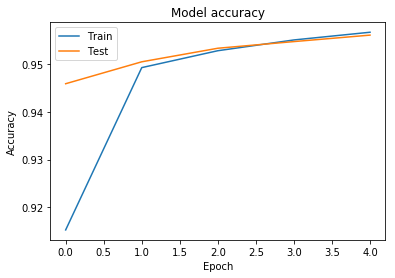

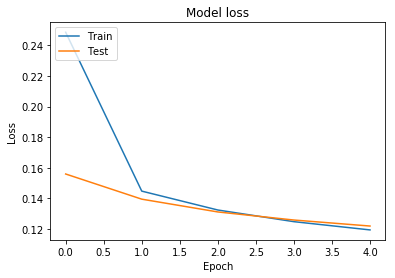

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Saving model

After training the model we can export it as a [SavedModel](https://www.tensorflow.org/beta/guide/saved_model) to deploy or share with others.

In [0]:
tf.saved_model.save(model,export_dir="my_model")

## Prediction

We can get the predictions for the validation data and check the confusion matrix to see the model's performance for each of the 5 classes. As `predict` method returns us the n-d array for probabilities for each class which we convert to class labels using `np.argmax`.

In [0]:
model =  tf.keras.models.load_model("my_model")
y_pred = model.predict(validation_data.batch(batch_size))

In [0]:
y_pred = np.argmax(y_pred,axis=1)

In [0]:
samples = file_paths[0:3]
for i,sample in enumerate(samples):
  f = open(sample)
  text = f.read()
  print(text[0:100])
  print("True Class:",sample.split("/")[0])
  print("Predicted Class : ",dir_names[y_pred[i]])
  f.close()
  


অভিনেতা হিসেবে রণবীর কাপুর কতটা শক্তিশালী তা বুঝতে ‘রাজনীতি’, ‘রকস্টার’, ‘ইয়ে জওয়ানি হ্যায় দিওয়ানি’
True Class: entertainment
Predicted Class :  state

কিশোরগঞ্জের তাড়াইল উপজেলার কারংকা গ্রামের ছেলে আবদুর রাজ্জাকের পুকুরে বিষ ঢেলে মাছ নিধন করেছে একদ
True Class: state
Predicted Class :  state

‘ব্যাটসম্যান-শাসিত’ হয়ে পড়ছে ক্রিকেট। চার শ রান হচ্ছে, ব্যাটসম্যানদের ডাবল সেঞ্চুরিও হয়ে যাচ্ছে।
True Class: sports
Predicted Class :  state


## Compare Performance

Now we can take the correct labels for the validation data from `labels`  and compare it with our predictions to get the [classification_report](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html). 

In [0]:
y_true = np.array(labels[train_size:])

In [0]:
print(classification_report(y_true,y_pred,target_names=dir_names))

               precision    recall  f1-score   support

      economy       0.78      0.82      0.80      3897
       sports       0.98      0.98      0.98     10204
entertainment       0.92      0.93      0.93      6256
        state       0.98      0.97      0.97     48512
international       0.92      0.94      0.93      6377

     accuracy                           0.96     75246
    macro avg       0.92      0.93      0.92     75246
 weighted avg       0.96      0.96      0.96     75246



We can also compare our model's performance with the published results obtained in the original [paper](https://www.researchgate.net/publication/328214545_BARD_Bangla_Article_Classification_Using_a_New_Comprehensive_Dataset) who report a 0.96 precision . The original  authors described many preprocessing steps done on the dataset like dropping punctuations and digits, removing top 25 most frequest stop words. As we can see in the classification_report  , we also gain a 0.96 precision and accuracy after training only 5 epochs without any preprocessing! 

In this example when we  created the keras layer from our embedding module we set `trainable=False`, which means the embedding weights will not be updated during training. Try setting it to True to reach reach 97% accuracy with this dataset with only 2 epochs. 